## EOF Analysis

GOAL: find patterns of global warming within the different models using change in TAS


In [1]:
#imports
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
from eofs import *
from eofs.standard import Eof
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyEOF
from pyEOF import * #pyEOF did not work for me/was not recognized by anaconda

In [4]:
#open processed data
ds_tas_hist_ssp585 = xr.open_dataset('processed_tas_regional_data.nc')
ds_tas_hist_ssp126 = xr.open_dataset('processed_tas_regional_ssp126_data.nc')
ds_tas_hist_ssp245 = xr.open_dataset('processed_tas_regional_ssp24

<xarray.Dataset>
Dimensions:  (lat: 175, lon: 358, model: 39)
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) object 'UKESM1-0-LL' 'CNRM-CM6-1-HR' ... 'MRI-ESM2-0'
Data variables:
    tas      (model, lat, lon) float32 ...

In [4]:
tas = ds_tas_hist_ssp585['tas'] #tas in this dataset was alr preprocessed for tas_anomalies
models = ds_tas_hist_ssp585['model']
lat = ds_tas_hist_ssp585['lat']
lon = ds_tas_hist_ssp585['lon']

In [5]:
tas

<xarray.DataArray 'tas' (model: 45, lat: 175, lon: 358)>
[2819250 values with dtype=float32]
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) object 'CNRM-CM6-1' 'GISS-E2-1-G' ... 'FGOALS-f3-L'

In [6]:
#lat weights are applied ... but i alr applied them in pre-processing
coslat = np.cos(np.deg2rad(tas.coords['lat'].values))
weights = np.sqrt(coslat)[...,np.newaxis]
#create solver 
solver_tas = Eof(tas.values, weights = weights)
#get leading EOF as correlation between the leading PC time series and the input TAS anomalies at each grid pt
eof1_tas = solver_tas.eofsAsCorrelation(neofs=1)
pc1_tas = solver_tas.pcs(npcs=1, pcscaling=1)

In [7]:
eof1_tas

array([[[        nan, -0.76002032, -0.76198366, ..., -0.74973161,
                 nan,         nan],
        [        nan, -0.75950095, -0.75985944, ..., -0.75570664,
                 nan,         nan],
        [        nan, -0.74622198, -0.7476025 , ..., -0.75044211,
                 nan,         nan],
        ...,
        [        nan, -0.91317215, -0.91106263, ..., -0.91826435,
                 nan,         nan],
        [        nan, -0.91106485, -0.91000406, ..., -0.91420391,
                 nan,         nan],
        [        nan, -0.90832985, -0.90809782, ..., -0.9096203 ,
                 nan,         nan]]])

In [17]:
pc1_tas

array([[-0.71467422],
       [ 0.94550846],
       [-1.73741067],
       [ 0.64684133],
       [ 0.64898131],
       [ 0.55423798],
       [-0.41371852],
       [-1.85730057],
       [-1.56457604],
       [-0.34580144],
       [-1.34669319],
       [-0.01148099],
       [ 1.22326898],
       [ 1.0198818 ],
       [ 1.27839592],
       [ 1.50384136],
       [-0.17207149],
       [-0.27047073],
       [ 0.02732644],
       [-0.38781628],
       [-0.20478015],
       [-0.53779447],
       [ 0.13971225],
       [ 0.6560207 ],
       [-0.08509195],
       [-0.58314438],
       [-0.21314403],
       [-0.33402383],
       [-0.60537997],
       [ 0.6016571 ],
       [ 1.22440266],
       [-0.95743971],
       [ 0.89378794],
       [ 0.02186199],
       [ 1.40012526],
       [ 0.78633252],
       [ 1.815641  ],
       [ 1.22796808],
       [-2.40483772],
       [-0.82487006],
       [ 0.9559428 ],
       [-1.63762548],
       [-0.82180903],
       [-0.15001231],
       [ 0.61023132]])

In [8]:
eof1_tas = xr.DataArray(eof1_tas, dims=["mode", "lat", "lon"], coords={"mode": [1], "lat": lat, "lon": lon})

In [9]:
eof1_tas = eof1_tas*-1 #invert
eof1_tas = (eof1_tas ** 2) * 100

In [10]:
eof1_tas[0]

<xarray.DataArray (lat: 175, lon: 358)>
array([[        nan, 57.76308798, 58.06190925, ..., 56.20974876,
                nan,         nan],
       [        nan, 57.68416984, 57.73863656, ..., 57.10925229,
                nan,         nan],
       [        nan, 55.68472506, 55.89094913, ..., 56.31633633,
                nan,         nan],
       ...,
       [        nan, 83.38833686, 83.00351076, ..., 84.3209421 ,
                nan,         nan],
       [        nan, 83.00391569, 82.8107392 , ..., 83.5768788 ,
                nan,         nan],
       [        nan, 82.50631104, 82.46416595, ..., 82.74090875,
                nan,         nan]])
Coordinates:
    mode     int32 1
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358

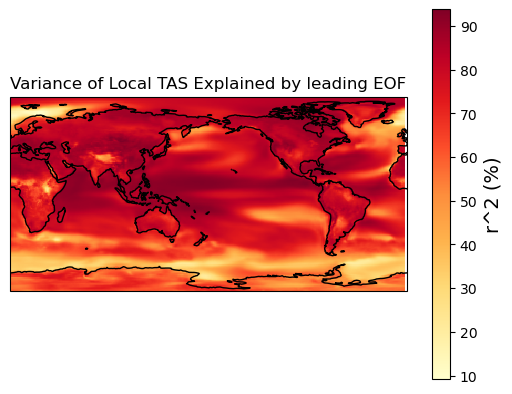

In [11]:
#plot the leading EOF expressed as correlation in the Pacific domain
#this shows the variance with eof1_tas inverted -> squared 
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
img = eof1_tas.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('Variance of Local TAS Explained by leading EOF')
cbar = plt.colorbar(img, ax=ax, orientation='vertical')
cbar.set_label('r^2 (%)', fontsize=14)

In [15]:
eof1_tas = xr.DataArray(eof1_tas, dims=["mode", "lat", "lon"], coords={"mode": [1], "lat": lat, "lon": lon})

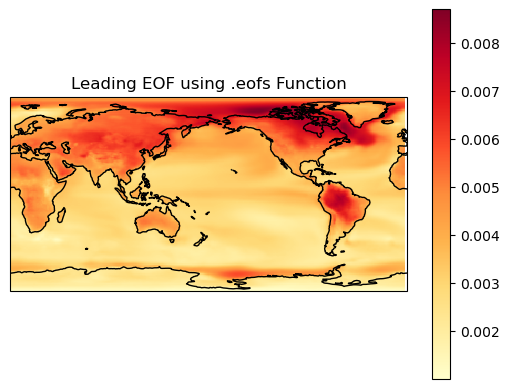

In [21]:
#plot the leading EOF expressed as correlation in the Pacific domain
#this shows the variance with eof1_tas inverted -> squared 
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
img = eof1_tas.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('Leading EOF using .eofs Function')
cbar = plt.colorbar(img, ax=ax, orientation='vertical')